In [1]:
import torch
import sys
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
def dist_metric(x,y):
    return(torch.norm(x-y).item())

def calculate_action(dist_list,k):
    action = torch.tensor([0.0,0.0,0.0])
    top_k_weights = torch.zeros((k,))
    for i in range(k):
        top_k_weights[i] = dist_list[i][0]

    top_k_weights = softmax(-1*top_k_weights)
    for i in range(k):
        action = torch.add(top_k_weights[i]*dist_list[i][1], action)

    return(action)

def extract_image(full_path):
    parts = full_path.split('/')
    return '/'.join(parts[-2:])

In [19]:
params = {}
params['root_dir'] = '/home/arvind/CMU/MAIL/VINN/VINN-Main/VINN-Sculpt/VINN-ACT/'  #'/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/' # This was changed
params['img_size'] = 624
params['layer'] = 'avgpool'
params['model'] = 'BYOL'
params['representation_model_path'] = 'chkpts/BYOL_100_X_batch_30.pt' # This was changed
params['eval'] = 0
params['representation'] = 0
params['dataset'] = 'X_Datasets'
params['architecture'] = 'ResNet'
params['t'] = 0
 

sys.path.append(params['root_dir'] + 'representation_models')
sys.path.append(params['root_dir'] + 'dataloaders')
print(sys.path)
from run_model import Encoder
from XDataset import XDataset

encoder = Encoder(params)
params['folder'] =  '/home/arvind/CMU/MAIL/VINN/VINN-Main/VINN-Sculpt/VINN-ACT/representation_data/X_all/train_all' # '/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/train_all'
train_dataset = XDataset(params, encoder)
params['folder'] =  '/home/arvind/CMU/MAIL/VINN/VINN-Main/VINN-Sculpt/VINN-ACT/representation_data/X_all/val_all'# '/home/arvindcar/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_data/X_all/val_all_trial'
val_dataset = XDataset(params, encoder)

['/home/arvind/CMU/MAIL/VINN/VINN-Main/VINN-Sculpt/VINN-ACT/nearest-neighbor-eval', '/home/arvind/anaconda3/envs/VINN-Sculpt/lib/python37.zip', '/home/arvind/anaconda3/envs/VINN-Sculpt/lib/python3.7', '/home/arvind/anaconda3/envs/VINN-Sculpt/lib/python3.7/lib-dynload', '', '/home/arvind/anaconda3/envs/VINN-Sculpt/lib/python3.7/site-packages', '/home/arvind/anaconda3/envs/VINN-Sculpt/lib/python3.7/site-packages/chamfer-2.0.0-py3.7-linux-x86_64.egg', '/home/arvind/anaconda3/envs/VINN-Sculpt/lib/python3.7/site-packages/IPython/extensions', '/home/arvind/.ipython', '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_models', '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/dataloaders', '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_models/', '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/dataloaders', '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/representation_models', '/home/aesee/CMU/MAIL_Lab/VINN/VINN-Sculpt/VINN-ACT/dataloaders', '/hom

100%|██████████| 12/12 [00:23<00:00,  1.95s/it]


In [20]:
mseLoss = torch.nn.MSELoss()
ceLoss = torch.nn.CrossEntropyLoss()

softmax = torch.nn.Softmax(dim=0)

In [21]:
def calculate_nearest_neighbors(query_set, dataset, k):
    loss = [0 for i in range(k)]
    selected_paths = []
    for query_index in tqdm(range(len(query_set))):
        dist_list = []
        query_embedding, query_translation, query_rotation, query_gripper, query_path = query_set[query_index]

        for dataset_index in range(len(dataset)):

            dataset_embedding, dataset_translation, dataset_rotation, dataset_gripper, dataset_path = dataset[dataset_index]
            distance = dist_metric(query_embedding, dataset_embedding)
            dist_list.append((distance, dataset_translation, dataset_path))

        dist_list = sorted(dist_list, key = lambda tup: tup[0])
        
        for i in range(k):
            pred_action = calculate_action(dist_list, i+1)
            loss[i] += mseLoss(pred_action,query_translation).item()
            if i == 10:
                selected_paths.append((extract_image(query_path), [extract_image(dist_list[j][2]) for j in range(i+1)]))

        

    return(loss, selected_paths)

In [22]:
val_loss, paths = calculate_nearest_neighbors(val_dataset, train_dataset, 50)

100%|██████████| 80/80 [00:01<00:00, 63.85it/s]


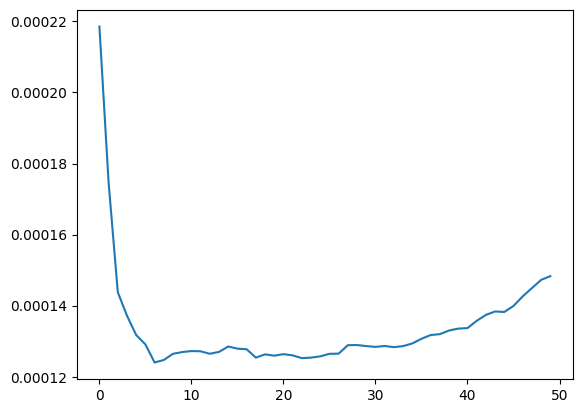

In [24]:
val_loss_scaled = [i / len(val_dataset) for i in val_loss]
x_axis = [i for i in range(len(val_loss))]
plt.plot(x_axis, val_loss_scaled)

In [25]:
print(paths[0])

('run_45/0000.jpg', ['run_41/0000.jpg', 'run_47/0000.jpg', 'run_46/0000.jpg', 'run_48/0000.jpg', 'run_49/0000.jpg', 'run_43/0000.jpg', 'run_40/0000.jpg', 'run_47/0005.jpg', 'run_49/0003.jpg', 'run_41/0001.jpg', 'run_40/0002.jpg'])


In [26]:
import numpy as np
np.argmin(np.array(val_loss_scaled))

6

In [9]:
# test_loss = calculate_nearest_neighbors(test_dataset, train_dataset, 50)

NameError: name 'test_dataset' is not defined

In [ ]:
test_loss_scaled = [i / len(test_dataset) for i in test_loss]
x_axis = [i for i in range(len(test_loss))]
plt.plot(x_axis, test_loss_scaled)

In [ ]:
min(test_loss_scaled)

0.19428218364976935